# `politician2vec` modelling pipeline

In [1]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
import multiprocessing
available_workers = multiprocessing.cpu_count()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs_2015_low.p'

In [4]:
# We remove parties with very few utterances (< 500), which prevents small/new parties and North-Atlantic MPs
# from skewing the embedding with very few, concentrated observations. We also remove non-affiliated MPs (UFG)
# KD is removed as they are only represented by one single MP during the entire period covered.

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP', 'M', 'DD', 'UFG', 'KD']")
parl_data.shape

(156448, 7)

In [5]:
parl_data['party'].value_counts()

S      32236
V      28410
DF     22067
EL     20054
SF     10523
LA     10512
KF     10065
RV      8882
ALT     7892
NB      5164
FG       643
Name: party, dtype: int64

In [6]:
parl_data['party'].value_counts(dropna = False)

S      32236
V      28410
DF     22067
EL     20054
SF     10523
LA     10512
KF     10065
RV      8882
ALT     7892
NB      5164
FG       643
Name: party, dtype: int64

In [7]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply(' '.join).reset_index()

In [8]:
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [9]:
ngram_options = {
    'min_count': 5,
    'threshold': 1,
    'delimiter': '_'
}

In [10]:
pol2vec_model = Politician2Vec(
    documents = docs,
    custom_clusters = parties,
    party_inference_method = 'mean',
    tokenizer = tokenize_docs,
    embedding_model = 'doc2vec',
    min_count = 50, # consider setting this higher!
    ngram_vocab = True,
    ngram_vocab_args = ngram_options,
    speed = 'fast-learn', # CHANGE FOR REAL RUNS
    workers = available_workers
    #doc2vec_vector_size = 300,
    #doc2vec_window = 8,
    #doc2vec_samples_threshold = 1e-5
)

2023-04-08 15:12:42,213 - politician2vec - INFO - Pre-processing documents for training
2023-04-08 15:14:40,294 - politician2vec - INFO - Creating joint document/word embedding
2023-04-08 15:35:40,111 - politician2vec - INFO - Estimating party positions using mean...
2023-04-08 15:35:40,534 - politician2vec - INFO - All done!


In [17]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_party(politician2vec_model, party_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    party.
    -------
    manual_num (int):  automatically assigned party number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given party.
        Default is to print all docs within a given party.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of party docs.
    '''

    num_parties = politician2vec_model.get_num_parties()
    party_words, word_scores, party_nums = politician2vec_model.get_parties(num_parties)

    # Get party sizes so we know max n docs
    party_sizes, party_nums = politician2vec_model.get_party_sizes()
    docs_to_return = party_sizes[party_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input party id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_party(
        party_num=party_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of party docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', party_words[party_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [18]:
word_vectors = pol2vec_model.model.wv
word_vectors.most_similar(positive = ['uværdig'], topn = 25)

[('praktiserer', 0.35297495126724243),
 ('værdig', 0.34014490246772766),
 ('nedslidte', 0.3300560414791107),
 ('ældre', 0.31717735528945923),
 ('værdighed', 0.30814701318740845),
 ('efterløn', 0.29649725556373596),
 ('else', 0.2935129404067993),
 ('arbejdsprøvninger', 0.29059648513793945),
 ('ældreplejen', 0.28816312551498413),
 ('pleje', 0.28652071952819824),
 ('mogens', 0.2845252752304077),
 ('arbejdsmarkedet', 0.2727634012699127),
 ('omsorg', 0.27026134729385376),
 ('pensionsalderen', 0.2687281370162964),
 ('begrundelse', 0.2671007513999939),
 ('eksempler', 0.2656663656234741),
 ('værdigt', 0.2641944885253906),
 ('seniorførtidspension', 0.26279646158218384),
 ('jakobsen', 0.26108503341674805),
 ('arbejdsevnen', 0.26085150241851807),
 ('lovbrud', 0.26033198833465576),
 ('landsretten', 0.2582843601703644),
 ('valgt', 0.2579176127910614),
 ('nedslidt', 0.25746211409568787),
 ('mors', 0.25461509823799133)]

In [19]:
'S',
#
'DF',
'EL',
'RV',
'SF',
'K',
'LA',
'UFG',

('UFG',)

In [20]:
inspect_party(pol2vec_model, 10, n_docs=1, query_substr=None)

--- TOP 50 WORDS ---
 ['frie grønne' 'borgerting' 'bruger ordet' 'ordføreren snakker'
 'nede omkring' 'frie verden' 'tænker hvorfor' 'resten regeringen'
 'gået siden' 'allerede dag' 'landbrugsaftalen' 'sidder tænker'
 'statsministeren resten' 'hjælpe ukrainske' 'igen tak' 'fortsat kæmpe'
 'gælder grønne' 'leve resten' 'ordet glad' 'frie liv' 'ukrainske'
 'kæmpe tak' 'tænker tænker' 'bruge ordet' 'anerkender simpelt' 'fik lyst'
 'demokratisk retning' 'hele grønne' 'frie rammer' 'frie samfund'
 'gjort kæmpe' 'ukrainske befolkning' 'resten verden' 'tænker okay'
 'kun snakker' 'frie lige' 'forskel lille' 'tager ordet'
 'ordføreren mener' 'anerkender ordføreren' 'debatten herinde'
 'mest grønne' 'glæder virkelig' 'tænker ordføreren' 'kæmpe forskel'
 'forskel hvordan' 'kæmpe næb' 'virkelig glad' 'sidder masse'
 'vores erhvervsordfører'] 

--- TOP 1 DOCS. SUBSTRING QUERY: None (n = 1) ---
 ['i frie grønne går vi selvfølgelig ind for frihed vi vil gerne kunne give kommunerne frihed til at lave

In [21]:
model_path = 'embedding_models/fastlearn_2015_low.txt'

In [22]:
pol2vec_model.save(model_path)

_____

## Viz dev

In [83]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [84]:
n_words = len(doc2vec_model.wv)
n_docs = len(doc2vec_model.dv)
vocab = pol2vec_model.vocab

In [85]:
## PARLIAMENT FASTLEARN
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'SF',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'UFG',
   9: 'Alternativet',
   10: 'Danmarksdemokraterne',
   11: 'Nye Borgerlige',
   12: 'Frie Grønne',
   13: 'Moderaterne',
   14: 'Kristendemokraterne'
}

In [86]:
# Hack to make top2vec models compatible with pol2vec
# def rename_attribute(obj, old_name, new_name):
#     obj.__dict__[new_name] = obj.__dict__.pop(old_name)

# rename_attribute(pol2vec_model, old_name='doc_top', new_name='doc_party')

In [87]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party sizes before filtering (party 19 is "Other"):

[[ 0 55]
 [ 1 44]
 [ 2 38]
 [ 3 17]
 [ 4 17]
 [ 5 17]
 [ 6 15]
 [ 7 13]
 [ 8 11]
 [ 9  4]
 [10  3]]


In [9]:
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

In [89]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [90]:
party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

In [91]:
party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())

In [92]:
#party_labels = party_df.drop_duplicates(keep = 'last', subset = 'party')[['party', 'party']].sort_values(by = 'party').set_index('party').reset_index(drop=True)

party_labels = party_df.drop_duplicates(keep = 'last', subset = 'party').sort_values(by='rank', ascending=False)#[['party', 'party']].sort_values(by = 'party').set_index('party').reset_index(drop=True)

In [93]:
party_labels

,doc,party,snippet,color,full_name,rank
232,232,S,tak for det nu insisterer ordføreren meget på ...,#C8042C,Yildiz Akdogan,55
230,230,V,ungdomsuddannelse for unge med særlige behov k...,#1A4289,Ulla Tørnæs,47
219,219,DF,tak her behandler vi et lovforslag som kommer ...,#265BA4,Tilde Bork,37
216,216,EL,tak jeg forstår på ordføreren at danmark nærme...,#BF2850,Søren Søndergaard,18
224,224,SF,ændringerne af tilskud om refusion på beskæfti...,#B42D27,Trine Torp,16
214,214,KF,tak fru mette frederiksen taler varmt om børne...,#24573E,Søren Pape Poulsen,15
233,233,RV,se det der blev sagt til sidst synes jeg var v...,#D82E8A,Zenia Stampe,15
231,231,LA,tak for det jeg har forstået at der kommer man...,#E7B657,Villum Christensen,13
229,229,ALT,mange tak jeg vil gerne spørge ordføreren om h...,#75FB4C,Ulla Sandbæk,11
181,181,NB,tak for ordet enhedslisten ønsker at sænke lan...,#1E4B57,Peter Seier Christensen,4


In [94]:
partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

In [95]:
partylabels

,party
232,S
230,V
219,DF
216,EL
224,SF
214,KF
233,RV
231,LA
229,ALT
181,NB


In [96]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

In [97]:
combined_hover

,doc,party,snippet,color,full_name,rank
0,0.0,DF,tak for det jeg er lidt forvirret på et højere...,#265BA4,Alex Ahrendtsen,37.0
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,55.0
3,3.0,LA,først og fremmest skal man vel ønske færøerne ...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,tak for en rigtig god tale det var også godt d...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
240,NaN,RV,NaN,black,NaN,NaN
241,NaN,LA,NaN,black,NaN,NaN
242,NaN,ALT,NaN,black,NaN,NaN
243,NaN,NB,NaN,black,NaN,NaN


In [28]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=3
    ).fit(
        np.vstack([
            pol2vec_model.document_vectors,
            pol2vec_model.party_vectors
            ])
    ) # label supervision: y = combined_hover['party'].astype('category').cat.codes

In [27]:
pol2vec_model.model.wv.most_similar(positive = ['forkasteligt'], topn = 50)

[('straffes', 0.3181499242782593),
 ('straffe', 0.3100847899913788),
 ('uacceptabelt', 0.3030604124069214),
 ('signal', 0.2788173258304596),
 ('bryder', 0.273366242647171),
 ('begår', 0.2700471580028534),
 ('straffen', 0.26365700364112854),
 ('moralsk', 0.2623308598995209),
 ('præventiv', 0.26179108023643494),
 ('straf', 0.2594963610172272),
 ('dybt', 0.2565496265888214),
 ('udansk', 0.25515347719192505),
 ('adfærd', 0.2529146075248718),
 ('opfører', 0.24968382716178894),
 ('straffet', 0.24908649921417236),
 ('bandekriminelle', 0.2474646121263504),
 ('sende', 0.2446073740720749),
 ('beskytte', 0.24431289732456207),
 ('dilemmafyldt', 0.24320930242538452),
 ('gerninger', 0.24249203503131866),
 ('ansvar', 0.24219101667404175),
 ('hårdere', 0.23859791457653046),
 ('racistisk', 0.23858274519443512),
 ('strafferammer', 0.23810158669948578),
 ('gerningsmænd', 0.23735415935516357),
 ('bødeniveauet', 0.2371104508638382),
 ('anmeldt', 0.23690862953662872),
 ('stjålet', 0.2339392900466919),
 ('hå

In [29]:
UMAP_projections = []

for seed in tqdm(range(0,1)):

    politician_mapper = umap.UMAP(
        n_neighbors=15,
        metric='cosine',
        n_components=3,
        random_state=seed
        ).fit(
            np.vstack([
                pol2vec_model.document_vectors,
                pol2vec_model.party_vectors
                ])
        )

    words_reduced = politician_mapper.transform(
        pol2vec_model.word_vectors
            )

    UMAP_projections.append((politician_mapper, words_reduced))

  0%|          | 0/1 [00:00<?, ?it/s]

In [243]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-whitegrid')
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

In [244]:
combined_hover[237:252]

,doc,party,snippet,color,full_name,rank
237,NaN,S,NaN,black,NaN,NaN
238,NaN,V,NaN,black,NaN,NaN
239,NaN,DF,NaN,black,NaN,NaN
240,NaN,EL,NaN,black,NaN,NaN
241,NaN,SF,NaN,black,NaN,NaN
242,NaN,RV,NaN,black,NaN,NaN
243,NaN,KF,NaN,black,NaN,NaN
244,NaN,LA,NaN,black,NaN,NaN
245,NaN,UFG,NaN,black,NaN,NaN
246,NaN,ALT,NaN,black,NaN,NaN


In [98]:
# Learning a 2D mapping of politician/party vectors and projecting words onto this "party space".
# Note that this is purely for visualisation purposes, since both words and documents are already
# embedded in the original 300D space--however, simply reducing the entire space at once runs the
# risk of the model distinguishing too clearly between word vecs and doc vecs and therfore placing
# them too far apart from each other.


for politician_mapper, words_reduced in UMAP_projections[0:1]:

    words_to_draw = [
        'mangfoldighed',
        'børn',
        'høj',
        'lav',
        'god',
        'dårlig',
        'muslimer',
        'diversitet',
        'national',
        'international'
    ]

    class PopulismWords:
        def __init__(self, projected_words, words_to_draw: 'list', antonym_pairs: 'list of tuples'):
            self.projection = projected_words
            self.vocab = words_to_draw
            self.antonyms = antonym_pairs
            self.word_coords = []

            for word in words_to_draw:
                self.word_coords.append(self.get_word_coords(word, self.projection))

        def get_word_coords(self, word, projected_words):
            idx = pol2vec_model.vocab.index(word)
            word_pos = projected_words[idx]

            return word_pos

        def get_antonym_coords(self, idx):
            antonym_coords = []
            pair = self.antonyms[idx]
            
            for word in pair:
                antonym_coords.append(self.get_word_coords(word, self.projection))

                xyz_coords = np.vstack(antonym_coords).T

            return xyz_coords[0], xyz_coords[1], xyz_coords[2]
        
        def write_words(self, ax):

            for word, word_pos in zip(self.vocab, self.word_coords):

                text_args = {
                'x': word_pos[0],
                'y': word_pos[1],
                'z': word_pos[2],
                'size': 12,
                'color': 'black',
                'bbox': dict(
                        facecolor='white',
                        alpha = .5,
                        edgecolor='none',
                        boxstyle='round,pad=0'
                        )
                    }

                if word in populism_words.antonyms[0]+populism_words.antonyms[len(populism_words.antonyms)-1]:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = text_args['color'],
                        bbox=text_args['bbox']
                    )

                else:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = 'dimgrey',
                        bbox=text_args['bbox']
                    )

        def draw_antonym_line(self, idx, ax, color = 'g', label = 'label here'):
            x, y, z = self.get_antonym_coords(idx)

            ax.plot(
                x,
                y,
                z,
                color = color,
                label = label
            )
            
    populism_words = PopulismWords(
        words_reduced,
        words_to_draw,
        antonym_pairs = [
            ('god', 'dårlig'),
            ('høj', 'lav'),
            ('national', 'international')
            ]
        )
    # TWITTER WORD SPACE MAPPING
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    xdata = politician_mapper.embedding_.T[0]
    ydata = politician_mapper.embedding_.T[1]
    zdata = politician_mapper.embedding_.T[2]

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.scatter3D(
        xdata,
        ydata,
        zdata,
        c=combined_hover['color'],
        cmap=combined_hover['color'],
        alpha = 0.75,
        s = 50
        )

    for vec_idx in range(237,252):
        x = politician_mapper.embedding_[vec_idx].T[0]
        y = politician_mapper.embedding_[vec_idx].T[1]
        z = politician_mapper.embedding_[vec_idx].T[2]
        
        ax.text(
            x+0.05,
            y+0.05,
            z+0.05,
            combined_hover.iloc[vec_idx]['party'],
            size=20,
            bbox=dict(
                facecolor='white',
                alpha = .5,
                edgecolor='none',
                boxstyle='round,pad=0'
                )
            )

    populism_words.write_words(ax)
    populism_words.draw_antonym_line(0, ax, color = 'r', label = 'Value-based politics')
    populism_words.draw_antonym_line(1, ax, color = 'b', label = 'Distributive politics')
    populism_words.draw_antonym_line(2, ax, color = 'b', label = 'inclusive politics/moralised politics')

    plt.legend(
        title = 'Ideological dimension\n',
        frameon = False,
        title_fontproperties={
            'size': 'large',
            'weight':'bold'
            }
        )

    #plt.savefig(f'/Users/mathiasbruun/Downloads/output_classic_seed_{seed}.png')
    
    plt.show()

NameError: name 'UMAP_projections' is not defined

In [ ]:
   # POPULISM TERMS
    #     'danske værdier',
    #     'internationalt samarbejde',
    #     'folkevalgte',
    #     'løgn',
    #     'sandhed',
    #     'onde',
    #     'forkert',
    #     'enighed',
    #     'dansk',
    #     'fair',
    #     'retfærdig',
    #     'skamme',
    #     'usandt',
    #     'ærlig',
    #     'skuffende',
    #     'danske statsborgere',
    #     'vilje',
    #     'værdi',
    #     'diversitet',
    #     'hårdtarbejdende',
    #     'vælgerne',
    #     'folket',
    #     'ligeglad',
    #     'selvbestemmelse',
    #     'byde velkommen'

In [25]:
# Learning a 2D mapping of politician/party vectors and projecting words onto this "party space".
# Note that this is purely for visualisation purposes, since both words and documents are already
# embedded in the original 300D space--however, simply reducing the entire space at once runs the
# risk of the model distinguishing too clearly between word vecs and doc vecs and therfore placing
# them too far apart from each other.


for politician_mapper, words_reduced in UMAP_projections[0:1]:

    words_to_draw = [
        # PC
        'løgn',
        'lyver folketinget',
        #'uærlig',
        'tale usandt',
        #'usandt folektinget',
        #'utopi',
        'voldsom centralisering',
        'løftebrud',
        'bag lyset',
        'politiske elite',
        'folkets vilje',
        'danske folk',
        'almindelige danskere',
        'almindelig dansker',
        'almindelig borger',
        'flere folkeafstemninger',
        'ved bedst',
        'danskere ønsker',

        # ---

        'repræsentativt demokrati',
        'lytte eksperter',
        'flere eksperter',
        'forskellige eksperter',
        'politisk ansvar',
        'folkevalgte',
        'parlamentarisk',
        'stærkt mandat',

        # AP
        'danske værdier',
        'normer værdier',
        'grænsekontrol',
        'permanent grænsekontrol',
        'illegale migranter',
        'økonomiske migranter',
        'ufravigelige krav',
        'udlændinge',

        # ---

        'større diversitet',
        'mere mangfoldighed',
        'danmark mangfoldigt',
        'ligestilling mangfoldighed',
        'mangfoldigt samfund',
        'tolerance',
        'ønsker imødekomme',
        'gerne imødekomme',
        'plads forskellighed',
        'forskellighed',
        'trods uenigheder',
        'åben diskussion',
        'bred diskussion',
        'fordomsfri diskussion',
        'god diskussion',
        'legitim diskussion',
        'godt kompromis',
        'fint kompromis',
        'fornuftigt kompromis',
        'kompromisets kunst',
        'kompromis',
        'hjælpe flygtninge',
        'diskrimination',

        # MP
        'eneste rigtige',
        'bruge magt',
        'snyder vægten',
        'moralsk forkasteligt',
        'moral',
        'værdier normer',
        'værdier moral',
        'værdier strider',
        'synes skammeligt',
        'burde skamme',
        'forarget',
        'forkasteligt',
        'fuldstændig utilstedeligt',
        'helt utilstedeligt',
        'synes utilstedeligt',
        'dybt uretfærdigt',
        'synes uretfærdigt',
        'hamrende uretfærdigt',
        'mest retfærdige',
        'bilde danskerne',
        'nedladende',

        # ---

        'faglige saglige',
        'faglige vurdering',
        'rent teknisk',
        'teknisk diskussion',
        'embedsværket',
        'neutral',
        'embedsfolk',
        'embedsværket',
        'gøre dommer',
        'tage forbehold',
        'objektive krav'
    ]

    class PopulismWords:
        def __init__(self, projected_words, words_to_draw: 'list', antonym_pairs: 'list of tuples'):
            self.projection = projected_words
            self.vocab = words_to_draw
            self.antonyms = antonym_pairs
            self.word_coords = []

            for word in words_to_draw:
                self.word_coords.append(self.get_word_coords(word, self.projection))

        def get_word_coords(self, word, projected_words):
            idx = pol2vec_model.vocab.index(word)
            word_pos = projected_words[idx]

            return word_pos

        def get_antonym_coords(self, idx):
            antonym_coords = []
            pair = self.antonyms[idx]
            
            for word in pair:
                antonym_coords.append(self.get_word_coords(word, self.projection))

                xyz_coords = np.vstack(antonym_coords).T

            return xyz_coords[0], xyz_coords[1], xyz_coords[2]
        
        def write_words(self, ax):

            for word, word_pos in zip(self.vocab, self.word_coords):

                text_args = {
                'x': word_pos[0],
                'y': word_pos[1],
                'z': word_pos[2],
                'size': 12,
                'color': 'black',
                'bbox': dict(
                        facecolor='white',
                        alpha = .5,
                        edgecolor='none',
                        boxstyle='round,pad=0'
                        )
                    }

                if word in populism_words.antonyms[0]+populism_words.antonyms[len(populism_words.antonyms)-2]+populism_words.antonyms[len(populism_words.antonyms)-1]:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = text_args['color'],
                        bbox=text_args['bbox']
                    )

                else:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = 'dimgrey',
                        bbox=text_args['bbox']
                    )

        def draw_antonym_line(self, idx, ax, color = 'g', label = 'label here'):
            x, y, z = self.get_antonym_coords(idx)

            ax.plot(
                x,
                y,
                z,
                color = color,
                label = label
            )
            
populism_words = PopulismWords(
    words_reduced,
    words_to_draw,
    antonym_pairs = [
        ('danske værdier', 'mangfoldighed'),
        ('politiske elite', 'flere eksperter'),
        ('moralsk forkasteligt','embedsværket')
        ]
    )
# PARLIAMENT WORD SPACE MAPPING
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = politician_mapper.embedding_.T[0]
ydata = politician_mapper.embedding_.T[1]
zdata = politician_mapper.embedding_.T[2]

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    )

for vec_idx in range(237,252):
    x = politician_mapper.embedding_[vec_idx].T[0]
    y = politician_mapper.embedding_[vec_idx].T[1]
    z = politician_mapper.embedding_[vec_idx].T[2]
    
    ax.text(
        x+0.05,
        y+0.05,
        z+0.05,
        combined_hover.iloc[vec_idx]['party'],
        size=20,
        bbox=dict(
            facecolor='white',
            alpha = .5,
            edgecolor='none',
            boxstyle='round,pad=0'
            )
        )

populism_words.write_words(ax)
#populism_words.draw_antonym_line(0, ax, color = 'r', label = 'Anti-pluralism vs. inclusion')
#populism_words.draw_antonym_line(1, ax, color = 'b', label = 'People-centrism vs. distributed legitimacy')
#populism_words.draw_antonym_line(2, ax, color = 'g', label = 'Moralised vs. technocratic politics')

plt.legend(
    title = 'Ideological dimension\n',
    frameon = False,
    title_fontproperties={
        'size': 'large',
        'weight':'bold'
        }
    )
#plt.savefig(f'/Users/mathiasbruun/Downloads/output_classic_seed_{seed}.png')

ax.plot(
    test_dims[0:2,0],
    test_dims[0:2,1],
    test_dims[0:2,2],
    c='r'
    )

ax.plot(
    test_dims[2:4,0],
    test_dims[2:4,1],
    test_dims[2:4,2],
    c='b'
    )

ax.plot(
    test_dims[4:6,0],
    test_dims[4:6,1],
    test_dims[4:6,2],
    c='g'
    )

plt.show()

NameError: name 'UMAP_projections' is not defined

In [99]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [100]:
from itertools import combinations
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        #return Politician2Vec._l2_normalize(mean_vec(self.vecs['present'])), Politician2Vec._l2_normalize(mean_vec(self.vecs['absent']))
        return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent']) # TODO: Figure out whether or not to normalise!

    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [164]:
[w for w in pol2vec_model.vocab if 'danskerne' in w]

['danskerne',
 'danskernes',
 'danskerne leve',
 'beskytte danskerne',
 'valgt danskerne',
 'varetage danskernes',
 'give danskerne',
 'danskerne danskerne',
 'danskerne trygge',
 'danskernes frie',
 'giver danskerne',
 'danskerne betaler',
 'danskerne stemmer',
 'danskerne får',
 'sikre danskernes',
 'tillid danskerne',
 'danskerne flest',
 'størstedelen danskerne',
 'danskernes frihed',
 'øge danskernes',
 'danskernes frihedsrettigheder',
 'afgifter danskerne',
 'danskerne fattigere',
 'danskernes tillid',
 'danskernes sundhed',
 'danskerne oplever',
 'fordel danskerne',
 'spørger danskerne',
 'pct danskerne',
 'danskernes velfærd',
 'danskernes økonomi',
 'hjælpe danskerne',
 'bede danskerne',
 'pålægge danskerne',
 'danskerne rigere',
 'danmark danskernes',
 'danskernes hverdag',
 'danskernes privatøkonomi',
 'danskernes forbrug',
 'givet danskerne',
 'forbedre danskernes',
 'danskernes vegne',
 'danskernes interesser',
 'danmark danskerne',
 'danskerne lever',
 'beskytte danskerne

In [203]:
PC_present_words = [
    'løgn',
    #'lyver folketinget',
    #'uærlig',
    'tale usandt',
    #'usandt folektinget',
    #'utopi',
    #'voldsom centralisering',
    'løftebrud',
    'bag lyset',
    'politiske elite',
     'folkets vilje',
    'danskere ønsker',
    'danskerne bestemmer',
    #'danske folk',
    'danske folks',
    'almindelige danskere',
    #'almindelig dansker',
    #'almindelig borger',
    #'flere folkeafstemninger',
    #'ved bedst'
    ]

PC_absent_words = [
    'repræsentativt demokrati',
    'lytte eksperter',
    #'flere eksperter',
    #'forskellige eksperter',
    'politisk ansvar',
    'folkevalgte',
    'parlamentarisk',
    'stærkt mandat'
    ]

AP_present_words = [
    'danske værdier',
    'normer værdier',
    #'grænsekontrol',
    'permanent grænsekontrol',
    'illegale migranter',
    'islamisering',
    #'økonomiske migranter',
    #'ufravigelige krav',
    'udlændinge',
    'kultur tradition'
    ]

AP_absent_words = [
    #'større diversitet',
    'ligestilling mangfoldighed',
    #'danmark mangfoldigt',
    #'mangfoldigt samfund',
    'tolerance',
    #'ønsker imødekomme',
    # 'gerne imødekomme',
    'plads forskellighed',
    'skader integrationen',
    #'forskellighed',
    'trods uenigheder',
    'åben diskussion',
    #'bred diskussion',
    'fordomsfri diskussion',
    #'god diskussion',
    #'legitim diskussion',
    #'godt kompromis',
    #'fint kompromis',
    'fornuftigt kompromis',
    #'kompromisets kunst',
    #'kompromis',
    'hjælpe flygtninge',
    'racisme diskrimination'
    ]

MP_present_words = [
    'eneste rigtige',
    'bruge magt',
    'snyder vægten',
    'moralsk forkasteligt',
    #'moral',
    #'værdier normer',
    #'værdier moral',
    'værdier strider',
    #'synes skammeligt',
    'burde skamme',
    'forarget',
    'forkasteligt',
    #'fuldstændig utilstedeligt',
    'helt utilstedeligt',
    #'synes utilstedeligt',
    'dybt uretfærdigt',
    #'synes uretfærdigt',
    #'hamrende uretfærdigt',
    #'mest retfærdige',
    'bilde danskerne',
    'nedladende'
    ]

MP_absent_words = [
    'faglige saglige',
    #'faglige vurdering',
    'rent teknisk',
    #'teknisk diskussion',
    'embedsværket',
    'neutral',
    #'embedsfolk',
    'gøre dommer',
    'tage forbehold',
    'objektive krav',
    'objektivt set'
    ]

In [204]:
PC_dimension = Subdimension(
    present_words=PC_present_words,
    absent_words=PC_absent_words
    )

AP_dimension = Subdimension(
    present_words=AP_present_words,
    absent_words=AP_absent_words
    )

MP_dimension = Subdimension(
    present_words=MP_present_words,
    absent_words=MP_absent_words
    )

In [205]:
print(PC_dimension.words)
print(len(PC_dimension.vecs['present']))

{'present': ['løgn', 'tale usandt', 'løftebrud', 'bag lyset', 'politiske elite', 'folkets vilje', 'danskere ønsker', 'danskerne bestemmer', 'danske folks', 'almindelige danskere'], 'absent': ['repræsentativt demokrati', 'lytte eksperter', 'politisk ansvar', 'folkevalgte', 'parlamentarisk', 'stærkt mandat']}
10


In [206]:
# PC_dimension.add_words(['folket', 'almindelig dansker'], present=True)
# print(PC_dimension.words)
# print(len(PC_dimension.vecs['present']))

In [207]:
# map a subdimension object to the learned 3D space:
# def map_subdim_to_learned_space(vecs, politician_mapper):
#     return politician_mapper.transform(vecs)


In [208]:
# Present:
for subdimension in [PC_dimension, AP_dimension, MP_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=True, min_size=6, max_size=8, replace=True)
    print(best_words)

# Absent:
for subdimension in [PC_dimension, AP_dimension, MP_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=False, min_size=6, max_size=8, replace=True)
    print(best_words)


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.613
['tale usandt', 'politiske elite', 'folkets vilje', 'danskere ønsker', 'danske folks', 'almindelige danskere']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.527
['danske værdier', 'normer værdier', 'permanent grænsekontrol', 'illegale migranter', 'udlændinge', 'kultur tradition']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.629
['eneste rigtige', 'moralsk forkasteligt', 'burde skamme', 'helt utilstedeligt', 'dybt uretfærdigt', 'bilde danskerne']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.382
['repræsentativt demokrati', 'lytte eksperter', 'politisk ansvar', 'folkevalgte', 'parlamentarisk', 'stærkt mandat']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.614
['ligestilling mangfoldighed', 'plads forskellighed', 'trods uenigheder', 'åben diskussion', 'fordomsfri diskussion', 'racisme diskrimination']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.577
['faglige saglige', 'rent teknisk', 'gøre dommer', 'tage forbehold', 'objektive krav', 'objektivt set']


In [209]:
PC_present, PC_absent = PC_dimension.calc_subdim_vecs()
AP_present, AP_absent = AP_dimension.calc_subdim_vecs()
MP_present, MP_absent = MP_dimension.calc_subdim_vecs()


PC_axis = PC_present - PC_absent
AP_axis = AP_present - AP_absent
MP_axis = MP_present - MP_absent

In [210]:
calc_cos_sim(MP_present, MP_absent)

0.85335743

In [211]:
# test_dims = map_subdim_to_learned_space(
#     np.vstack([
#         PC_present, PC_absent,
#         AP_present, AP_absent,
#         MP_present, MP_absent
#     ]),
#     politician_mapper
#     )

In [212]:
# assume we have a matrix of word and document vectors called `embedding_matrix`
# with shape (num_documents, embedding_dimension)
embedding_matrix = pol2vec_model.party_vectors

# assume we have three subdimension vectors called `v1`, `v2`, and `v3`
# with shape (embedding_dimension,)

# create a matrix called `projection_matrix` with shape (embedding_dimension, 3)
# that has the three subdimension vectors as columns
projection_matrix = np.stack((PC_axis, AP_axis, MP_axis), axis=1)

# project the document vectors onto the subspace described by the three
# subdimension vectors by multiplying the embedding matrix by the projection
# matrix 
# the resulting matrix will have shape (num_documents, 3)
projected_matrix = embedding_matrix.dot(projection_matrix)

# The resulting projected_matrix will be a matrix with shape (num_documents, 3)
# that represents the document vectors projected onto the subspace described by
# the three "special" vectors. Each row of the matrix corresponds to a document,
# and the three columns correspond to the three sub-dimensions of populism

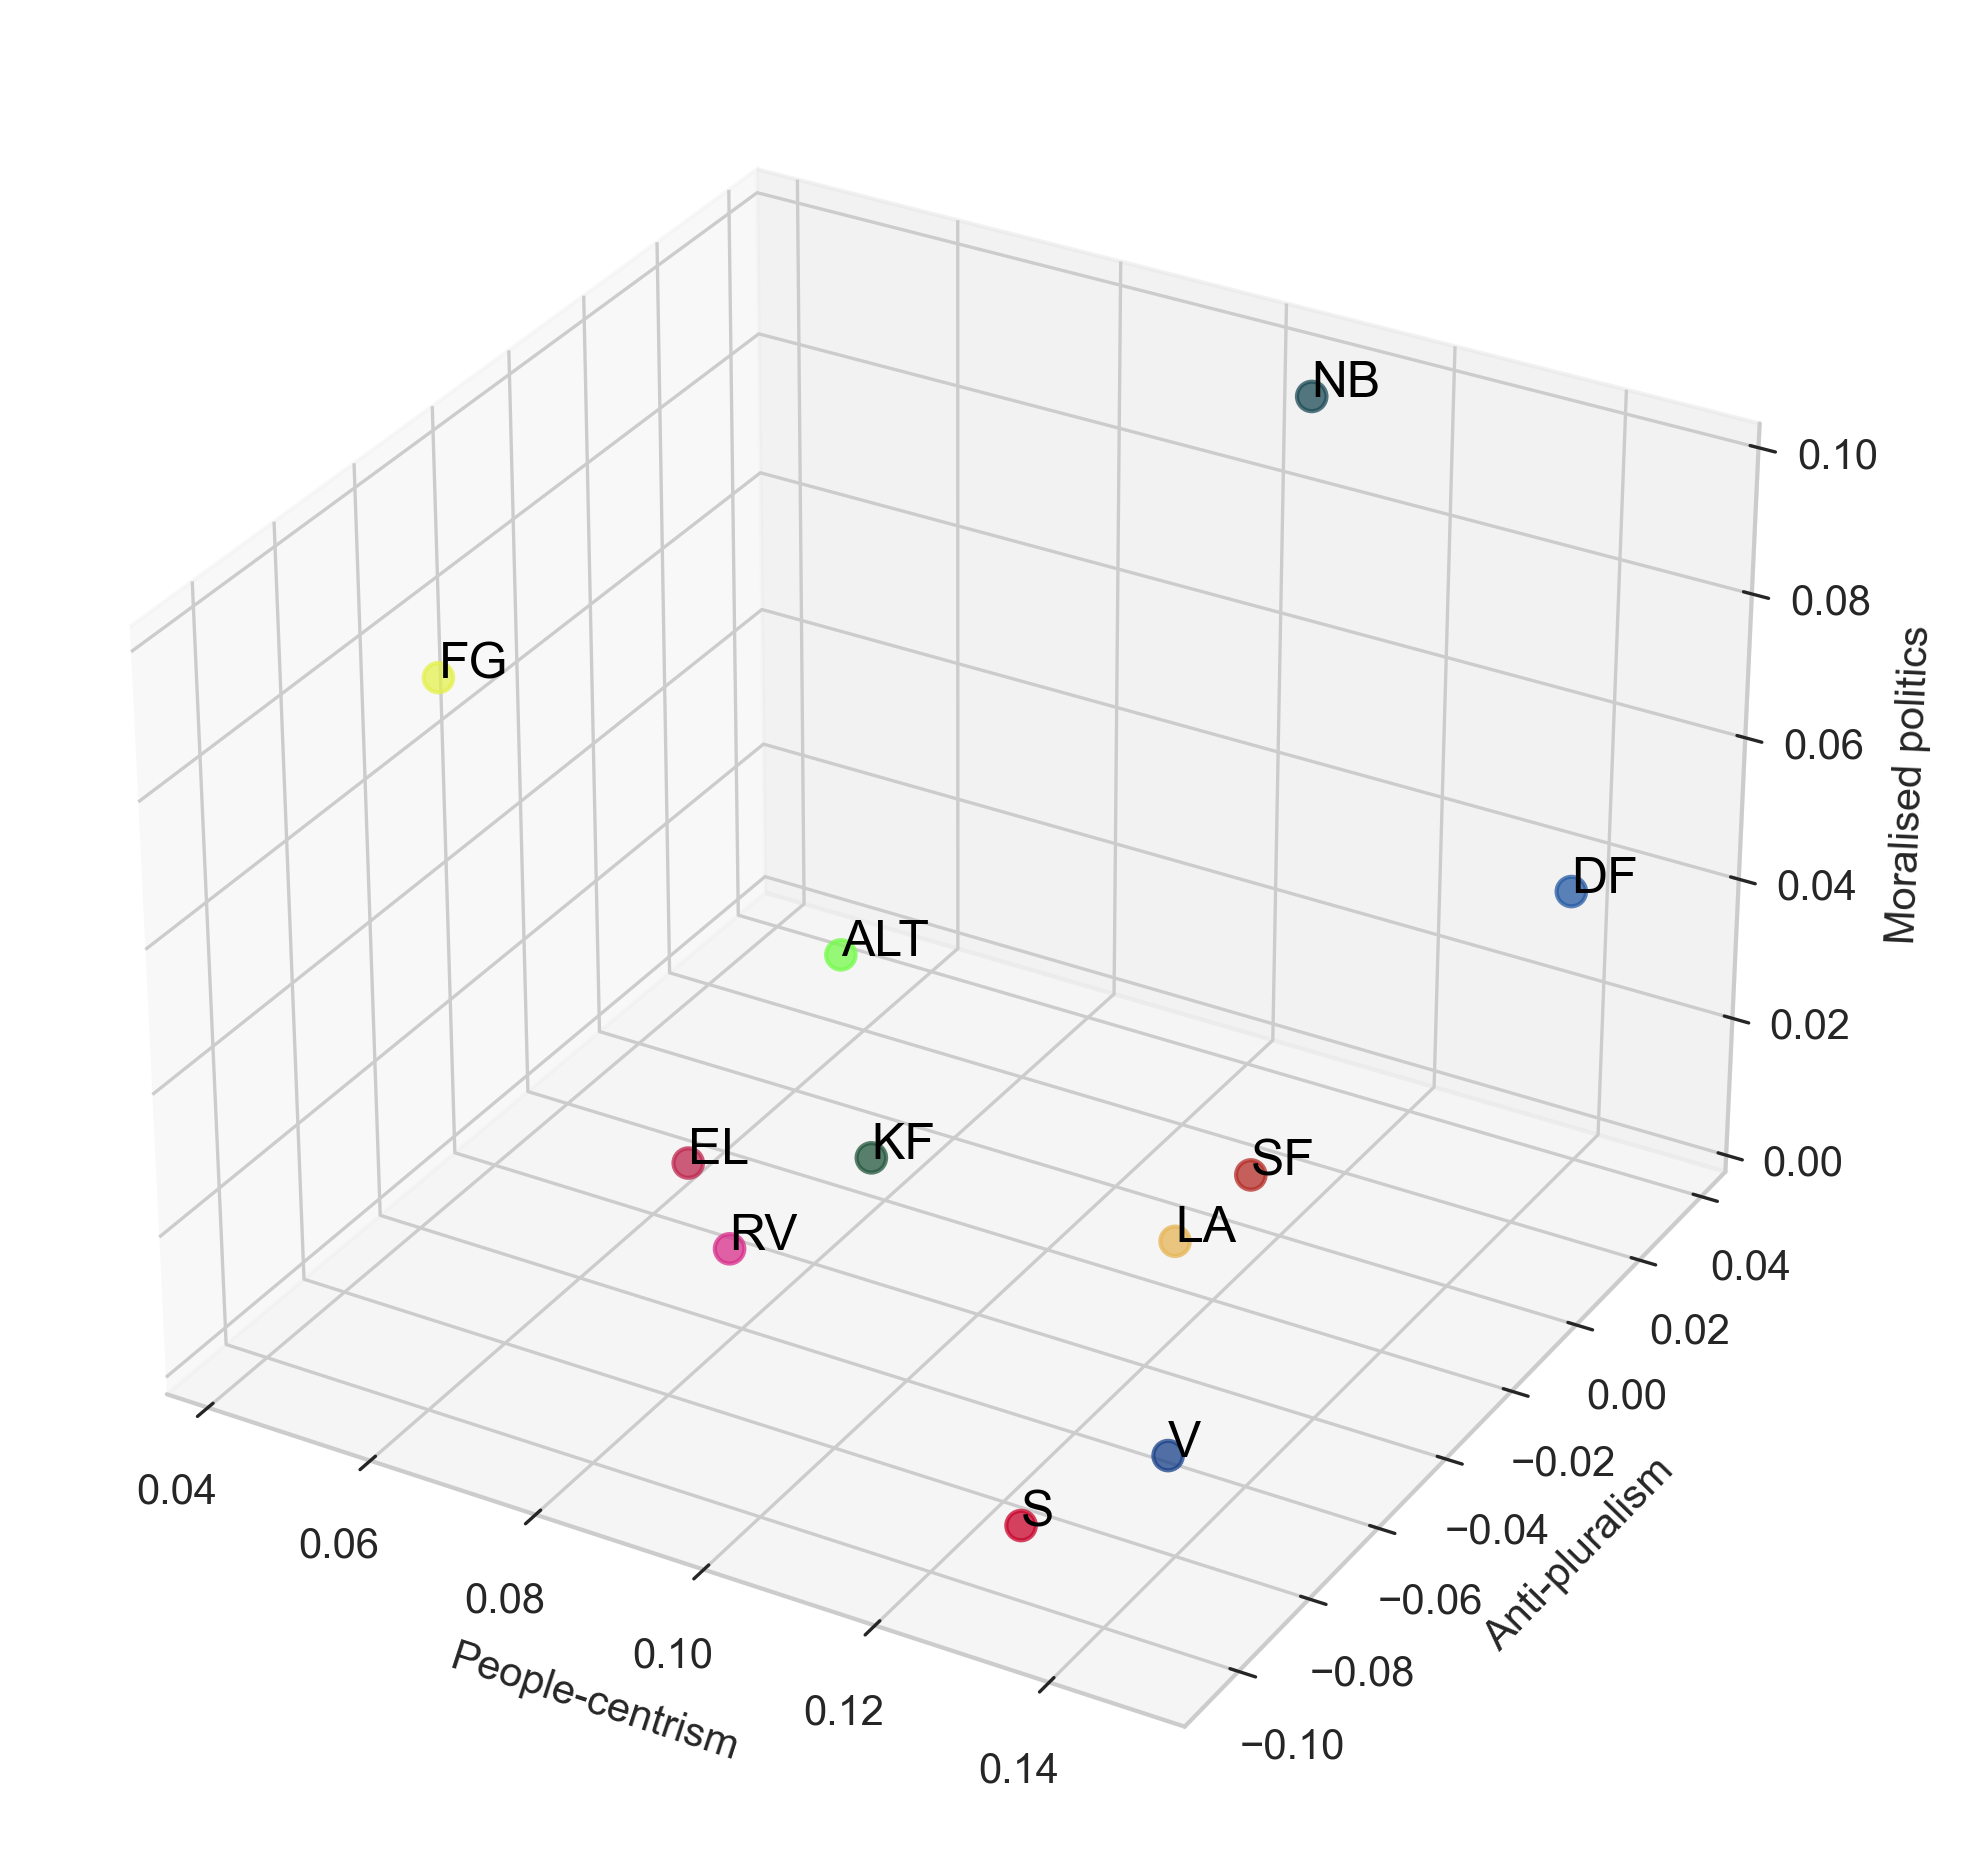

In [213]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

# Initialize the plot and set the axis labels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('People-centrism')
ax.set_ylabel('Anti-pluralism')
ax.set_zlabel('Moralised politics')

# Set the range of the axis
# ax.set_xlim([0.02, 0.125])
# ax.set_ylim([-0.01, 0.2])
# ax.set_zlim([0, 0.075])

# Create a scatter plot of the politician embeddings
xs = embeddings[:,0]
ys = embeddings[:,1]
zs = embeddings[:,2]
ax.scatter(xs, ys, zs, s=50, alpha=0.75, color=party_labels['color'])

for i, embedding in enumerate(embeddings):
    x, y, z = embedding
    ax.text(x, y, z, party_labels.iloc[i]['party'], color='black', size=12)

# Add selected word vectors and labels to the plot
# def plot_words(ax, dimension, projection_matrix, color, size=7):

#     for i, dimvec in enumerate(dimension.vecs['present']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['present'][i], color=color, size=size)

#     for i, dimvec in enumerate(dimension.vecs['absent']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0.25, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['absent'][i], color=color, size=size)

# plot_words(ax, PC_dimension, projection_matrix, 'red')
# plot_words(ax, AP_dimension, projection_matrix, 'blue')
# plot_words(ax, MP_dimension, projection_matrix, 'green')

# Show the plot
plt.show()

In [187]:
from adjustText import adjust_text

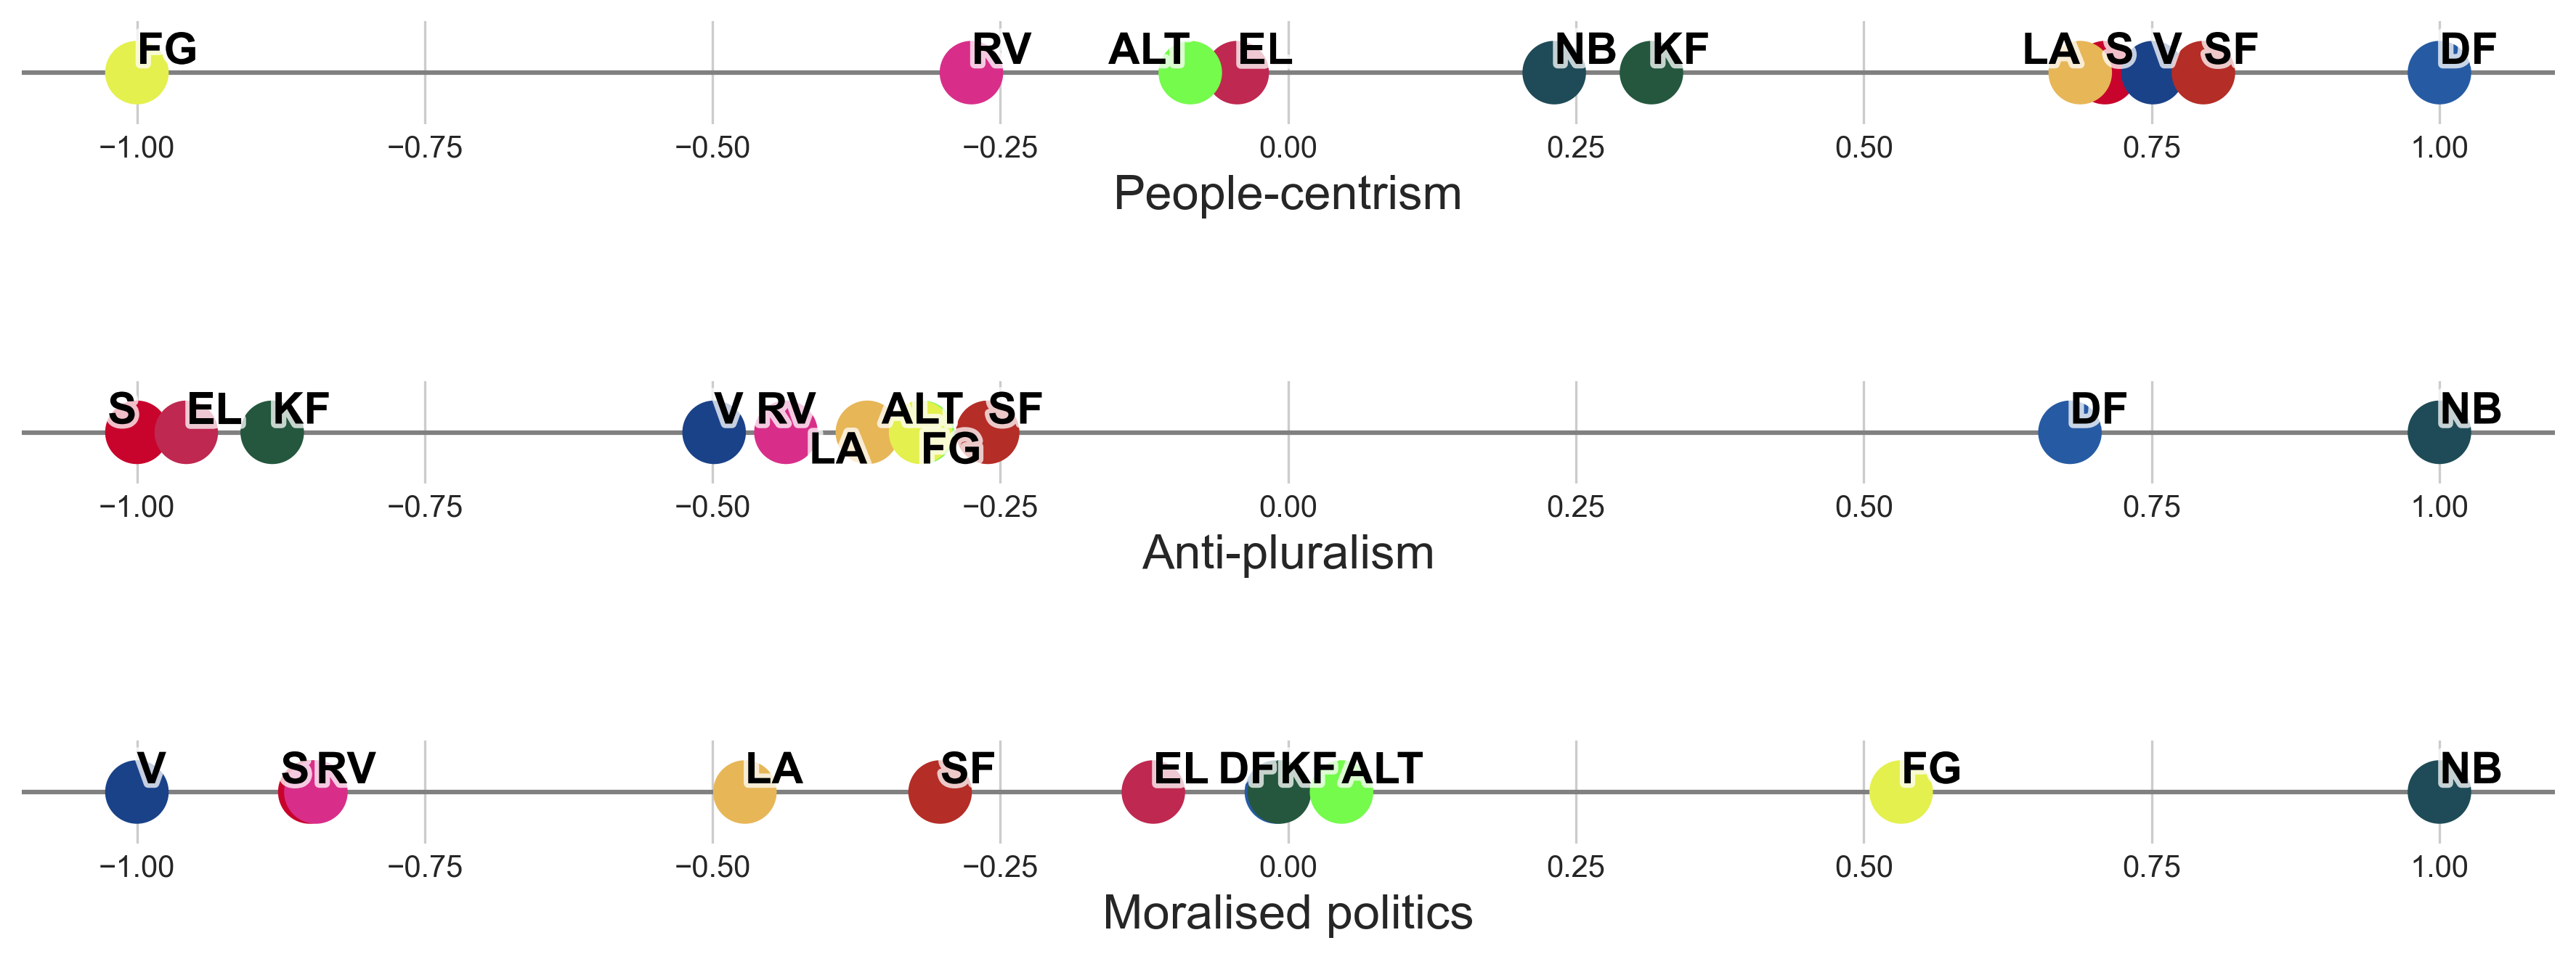

In [214]:
plt.style.use('seaborn-whitegrid')
colorlist = combined_hover.dropna()['color']
import matplotlib.patheffects as pe
#set display dpi to 300
plt.rcParams['figure.dpi'] = 300

# TODO: Just plot colour-coded party labels to improve data to ink ratio. Jitter only along y axis as needed.

# project politicians onto each subdimension
proj_dim1 = np.dot(pol2vec_model.party_vectors, PC_axis)
proj_dim2 = np.dot(pol2vec_model.party_vectors, AP_axis)
proj_dim3 = np.dot(pol2vec_model.party_vectors, MP_axis)

# rescale each dimension to be between -1 and 1
proj_dim1 = (proj_dim1 - proj_dim1.min()) / (proj_dim1.max() - proj_dim1.min()) * 2 - 1
proj_dim2 = (proj_dim2 - proj_dim2.min()) / (proj_dim2.max() - proj_dim2.min()) * 2 - 1
proj_dim3 = (proj_dim3 - proj_dim3.min()) / (proj_dim3.max() - proj_dim3.min()) * 2 - 1

# create 3x1 subplot
fig, axs = plt.subplots(3, 1, figsize=(15, 5))

# add space between subplots
fig.subplots_adjust(hspace=2.5)

# add hline at 0, behind the scatterplot points
for ax in axs:
    ax.axhline(y=0, color='grey', linestyle='-', linewidth=1.5)

# plot projection onto first subdimension
axs[0].scatter(proj_dim1, np.zeros_like(proj_dim1), c=party_labels['color'], s=400, zorder=2)
axs[0].set_xlabel('People-centrism', size=16)
axs[0].set_ylim(-0.1, 0.1)

# plot projection onto second subdimension
axs[1].scatter(proj_dim2, np.zeros_like(proj_dim2), c=party_labels['color'], s=400, zorder=2)
axs[1].set_xlabel('Anti-pluralism', size=16)
axs[1].set_ylim(-0.1, 0.1)

# plot projection onto third subdimension
axs[2].scatter(proj_dim3, np.zeros_like(proj_dim3), c=party_labels['color'], s=400, zorder=2)
axs[2].set_xlabel('Moralised politics', size=16)
axs[2].set_ylim(-0.1, 0.1)

# add party labels to each of the subplots without adjusting text positions
for i, party in enumerate(party_labels['party']):
    axs[0].text(proj_dim1[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])
    axs[1].text(proj_dim2[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])
    axs[2].text(proj_dim3[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])

# adjust text positions to avoid overlapping
for ax in axs:
    adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.55, force_text=0.5, expand_points=(1,1), expand_text=(1,1))

for ax in axs:
    ax.set_yticklabels([])
    ax.grid(False, axis = 'y', which = 'both')
    
    for spine in ax.spines.values():
        spine.set_visible(False)

# adjust text positions to avoid overlapping
for ax in axs:
    adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.55, force_text=0.5, expand_points=(1,1), expand_text=(1,1))

plt.show()

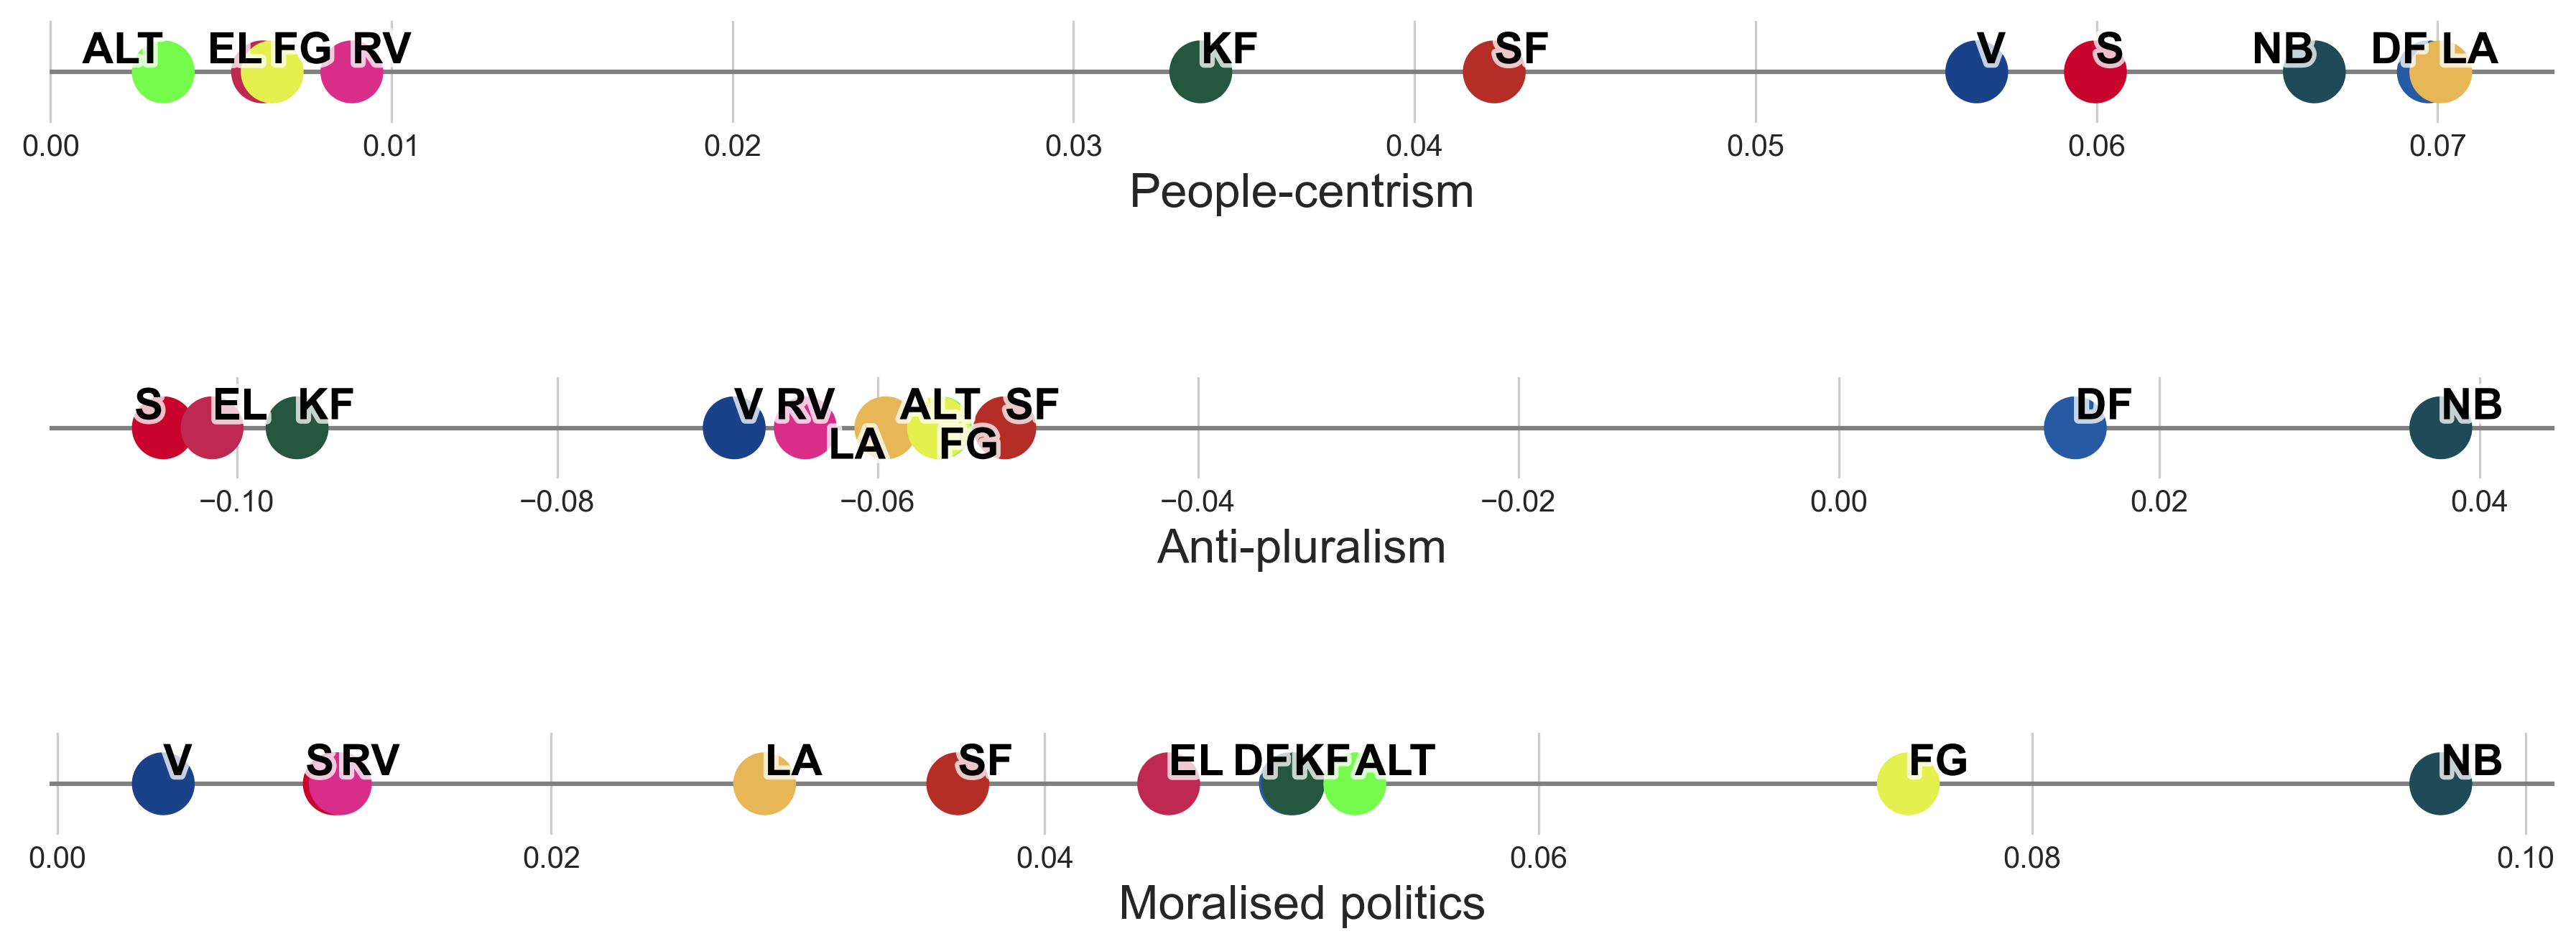

In [189]:
plt.style.use('seaborn-whitegrid')
colorlist = combined_hover.dropna()['color']
import matplotlib.patheffects as pe
#set display dpi to 300
plt.rcParams['figure.dpi'] = 300

# project politicians onto each subdimension
proj_dim1 = np.dot(pol2vec_model.party_vectors, PC_axis)
proj_dim2 = np.dot(pol2vec_model.party_vectors, AP_axis)
proj_dim3 = np.dot(pol2vec_model.party_vectors, MP_axis)

# rescale each dimension to be between -1 and 1
# proj_dim1 = (proj_dim1 - proj_dim1.min()) / (proj_dim1.max() - proj_dim1.min()) * 2 - 1
# proj_dim2 = (proj_dim2 - proj_dim2.min()) / (proj_dim2.max() - proj_dim2.min()) * 2 - 1
# proj_dim3 = (proj_dim3 - proj_dim3.min()) / (proj_dim3.max() - proj_dim3.min()) * 2 - 1

# create 3x1 subplot
fig, axs = plt.subplots(3, 1, figsize=(15, 5))

# add space between subplots
fig.subplots_adjust(hspace=2.5)

# add hline at 0, behind the scatterplot points
for ax in axs:
    ax.axhline(y=0, color='grey', linestyle='-', linewidth=1.5)

# plot projection onto first subdimension
axs[0].scatter(proj_dim1, np.zeros_like(proj_dim1), c=party_labels['color'], s=400, zorder=2)
axs[0].set_xlabel('People-centrism', size=16)
axs[0].set_ylim(-0.1, 0.1)

# plot projection onto second subdimension
axs[1].scatter(proj_dim2, np.zeros_like(proj_dim2), c=party_labels['color'], s=400, zorder=2)
axs[1].set_xlabel('Anti-pluralism', size=16)
axs[1].set_ylim(-0.1, 0.1)

# plot projection onto third subdimension
axs[2].scatter(proj_dim3, np.zeros_like(proj_dim3), c=party_labels['color'], s=400, zorder=2)
axs[2].set_xlabel('Moralised politics', size=16)
axs[2].set_ylim(-0.1, 0.1)

# add party labels to each of the subplots without adjusting text positions
for i, party in enumerate(party_labels['party']):
    axs[0].text(proj_dim1[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])
    axs[1].text(proj_dim2[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])
    axs[2].text(proj_dim3[i], 0, party, size=14.5, color='black', weight = 'bold', path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.75)])

# adjust text positions to avoid overlapping
for ax in axs:
    adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.55, force_text=0.5, expand_points=(1,1), expand_text=(1,1))

for ax in axs:
    ax.set_yticklabels([])
    ax.grid(False, axis = 'y', which = 'both')
    
    for spine in ax.spines.values():
        spine.set_visible(False)

# adjust text positions to avoid overlapping
for ax in axs:
    adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.55, force_text=0.5, expand_points=(1,1), expand_text=(1,1))

plt.show()

### Interactive UMAP plot (2D only)

In [ ]:
plab_source = ColumnDataSource(dict(
    x = list(mapper.embedding_.T[0][166:]),
    y=list(mapper.embedding_.T[1][166:]),
    text=list(combined_hover.loc[combined_hover['full_name'].isna(), 'party'].values)
    ))

In [ ]:
# PARLIAMENT
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [ ]:
# META
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [ ]:
# TWITTER
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

### PCA: Project parties to first principal component

In [ ]:
pca = PCA(n_components=3)

In [ ]:
reduced = pca.fit_transform(
    np.vstack([
        #pol2vec_model.document_vectors,
        pol2vec_model.party_vectors
        ]))

In [ ]:
only_party_labs

In [ ]:
only_party_labs = combined_hover
only_party_labs.loc[only_party_labs['full_name'].notna(),'party'] = ''
only_party_labs = only_party_labs[241:].reset_index(drop=True)

In [ ]:
only_party_labs['color'] = only_party_labs['party'].map(colormap)
#only_party_labs['color'] = only_party_labs['color'].fillna('lightgrey')

In [ ]:
only_party_labs

In [ ]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

In [ ]:
# META
fig = plt.figure(figsize=(15,15))
component = 1

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

In [ ]:
# TWITTER
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

for i in range(len(reduced)):
    plt.annotate(only_party_labs['party'][i], (reduced.T[component][i]+0.01, reduced.T[component][i]-0.035), size = 15, rotation = 45)

### Static 3D UMAP plot

In [ ]:
# TWITTER PREPROCCED NAMES
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(241,260):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# META
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(201,217):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

In [ ]:
# TWITTER
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

____

In [ ]:
with open('vocab.txt', 'w') as f:
    f.write('\n'.join(pol2vec_model.vocab))


## TensorBoard exports

In [ ]:
doc2vec2tensor(
    doc2vec_model,
    temp_w2v_path = 'tensorboard_input/temp/doc_tensor_meta.w2v',
    tsv_prefix = 'tensorboard_input/meta',
    output_docvecs = True,
    output_wordvecs = False
)

In [ ]:
metadata2tensor(
    party_df,
    metadata_path = 'tensorboard_input/meta_metadata.tsv',
    label_list = party_labels
)

In [ ]:
# test read of tensor output
with open('tensorboard_input/meta_tensor.tsv','r') as r:
    lines_test = r.readlines()

len(lines_test)

In [ ]:
def partyvecs2tensor(party_vecs, out_path):
    vec_strs = []

    for vec in party_vecs:
        vec_str = ''.join([str(val) +'\t' for val in vec]).rstrip('\t')
        vec_strs.append(vec_str)

    tensor_str = '\n'.join(vec_strs)
    
    with open(out_path, 'w') as f:
        f.write(tensor_str)

In [ ]:
def concat_tensors(tensor_files, out_path):
    tensor_strs = []
    
    for file in tensor_files:
        tensor_str = pd.read_csv(file, sep = '\t', header = None)
        tensor_strs.append(tensor_str)
    
    concat_tensor = pd.concat(tensor_strs)
    
    concat_tensor.to_csv(out_path, sep = '\t', header = False, index = False)

In [ ]:
partyvecs2tensor(
    party_vecs = pol2vec_model.party_vectors,
    out_path = 'tensorboard_input/meta_parties.tsv'
)

In [ ]:
label_df = pd.DataFrame(party_labels, index = ['doc']).T
#label_df['party'] = ''

In [ ]:
label_df.to_csv(
    'tensorboard_input/meta_parties_metadata.tsv',
    sep = '\t',
    header = False,
    index = False
)

In [ ]:
# Combine docvecs and partyvecs
politician_file = 'tensorboard_input/meta_tensor.tsv'
party_file = 'tensorboard_input/meta_parties.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined.tsv')

In [ ]:
# Combine metadata
politician_file = 'tensorboard_input/meta_metadata.tsv'
party_file = 'tensorboard_input/meta_parties_metadata.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined_metadata.tsv')